In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.font_manager
from scipy import stats

from scripts import preprocessing as sprocessing
from scripts import clockface_plots as sclockface
from scripts import heatmap_plots as sheatmap
from scripts import config as sconfig
from scripts import utils as sutils
from scripts import dataloaders as sdataloaders
from scripts import similarity_processor as ssimilarity
from scripts import constants as sconstants
from scripts import day_night_comparisons as sday
from scripts.path_utils import *
from scripts.enums import Columns, FactTypes, ContentType, Clusters

# Loading and preprocessing

In [2]:
np.random.seed(0)
config = sconfig.Config(date_from = '2020-01-22')
dl = sdataloaders.APILoader(config)
country_config = sconfig.CountryConfig(LABEL='ITA', TIME_ZONE='Europe/Rome')
processor = sprocessing.DataProcessor(config)

In [3]:
processor.load_and_prepare(dl, country_config)

ITA in store from 2020-01-22 to 2022-08-01. Store contains ['/ALL', '/DEU', '/ITA', '/ITA_preprocessed', '/NONE'].
Getting DF from Store for the dates 2020-01-22 to 2022-08-01
where_clause:  Datetime >= start_date & Datetime < end_date 
Completed loading DF of size  (18846723, 9)
Converting dateTime
Converting  Columns.YEAR
Converting  Columns.MONTH
Converting  Columns.MIN_BINS15
Finding posts per user


In [4]:
from scripts.path_utils import *
TYPE='all'
activity_path_manager = ActivityPathManager(config, country_config.LABEL, TYPE)
ratio_path_manager = MachinatedPathManager(config, country_config.LABEL, TYPE)

In [5]:
unverified_mask = ~processor.all[Columns.VERIFIED.value]
known_mask = processor.all[Columns.FACTTYPE.value]!=FactTypes.OTHER.value.name

In [6]:
all_col = pd.read_parquet(get_cluster_col_path(activity_path_manager))
processor.all[Columns.CLUSTER.value] = all_col

In [7]:
no_bots_mask = processor.all[Columns.CLUSTER.value] != Clusters.BOT.value
type_mask = no_bots_mask

In [8]:
import pickle
with open(get_waking_time_path(config, country_config, TYPE), 'rb') as f:
    waking_times = pickle.load(f)

In [9]:
activity_col=Columns.ACTIVITY_WEIGHTED.value
ratio_col=Columns.RATIO_BY_USER.value

In [10]:
activity = activity_path_manager.load('signal')
ratio = ratio_path_manager.load('signal')
activity_smoothed = activity_path_manager.load('fourier')
ratio_smoothed = ratio_path_manager.load('fourier')

# Corpus, general

Tweets were collected based on keywords and hashtags related to Covid (as described in Gallotti2020). In the following, we only look at Tweets that were classified with a FactType, meaning that they contain a URL in one of the domains in the database by Gallotti2020.
We assume that circadian rhythms have a similar effect on tweets with and without URLS.

In [15]:
t = pd.crosstab(processor.all[Columns.VERIFIED.value], processor.all[Columns.CLUSTER.value], margins=True, dropna=False)
t[[c for c in Clusters]+[c for c in t.columns if c not in list(Clusters)]]

cluster,infrequent type,morning type,intermediate type,evening type,bot,All
verified,,,,,,
False,7795201,3146942,3961120,2887650,61469,17852382
True,63008,61542,201791,31659,1844,359844
All,7858209,3208484,4162911,2919309,63313,18212226


In [16]:
pd.crosstab(processor.all.loc[no_bots_mask, Columns.VERIFIED.value], processor.all.loc[no_bots_mask, Columns.FACTTYPE.value], margins=True, dropna=False) \
    [[f.value.name for f in FactTypes] + ['All']]

FactType2,Science,Mainstream Media,Satire,Clickbait,Other,Political,Fake or hoax,Conspiracy & junk science,All
verified,,,,,,,,,
False,18597,719196,4289,12189,16829168,98202,43716,65556,17790913
True,234,38271,12,8,318700,498,172,105,358000
All,18831,757467,4301,12197,17147868,98700,43888,65661,18148913


In [17]:
pd.crosstab(processor.all[Columns.VERIFIED.value], processor.all[Columns.IS_BOT.value], margins=True, dropna=False, normalize=True)

isBot,False,True,All
verified,,,
False,0.547728,0.432514,0.980242
True,0.003867,0.015891,0.019758
All,0.551595,0.448405,1.000000


In [18]:
def get_facttype_stats(df):
    aggr_dict = {Columns.TWEET_ID.value: 'count', Columns.NUM_POSTS.value: ('mean', 'median')}
    facttype_stats= df.groupby(Columns.FACTTYPE.value).agg(aggr_dict)
    facttype_stats = facttype_stats.loc[list(sconstants.FACTTYPE_NAME_MAP.keys())].rename(sconstants.FACTTYPE_MAP, axis=0)
    facttype_stats.loc[ContentType.MANIPULATED.value]=df.groupby(Columns.MACHINATED.value).agg(aggr_dict).loc[True].values
    facttype_stats.columns=['total posts', 'mean posts per author', 'median posts per author']
    facttype_stats.index.name= ''
    return facttype_stats

<p id="SupplTab2">Supplementary Table 2</p>

In [19]:
facttype_stats_style = get_facttype_stats(processor.all.loc[type_mask]).style.format('{:,.0f}')
activity_path_manager.to_latex(facttype_stats_style, "fact_type_stats.tex", "Statistics for each content type.")
facttype_stats_style

,total posts,mean posts per author,median posts per author
,,,
Science,"18,831","2,261",484
Mainstream Media,"757,467","2,683",672
Satire,"4,301",734,170
Clickbait,"12,197",735,39
Other,"17,147,868","1,775",364
Political,"98,700","2,755",721
Fake or hoax,"43,888","2,601","1,143"
Conspiracy & junk science,"65,661","4,275","1,679"
potentially machinated,"208,249","3,202","1,110"


# All and unverified

In [20]:
by_cluster_verified = sprocessing.group_by_with_total(processor.all.loc[known_mask], group_by_cols=[Columns.VERIFIED, Columns.MACHINATED], total_for_idx=-2)
by_cluster_verified_ft = sprocessing.group_by_with_total(processor.all.loc[known_mask], group_by_cols=[Columns.VERIFIED, Columns.FACTTYPE], total_for_idx=-2)
vmask = lambda df: df.loc[df.index.get_level_values(0).isin([True, False]), [Columns.RATIO_BY_TWEET.value, Columns.RATIO_BY_USER.value]].unstack(level=0)

ratios_by_verified = vmask(by_cluster_verified_ft).loc[FactTypes.known_order(attribute='name')]
ratios_by_verified.loc[ContentType.MANIPULATED.value] = vmask(by_cluster_verified).loc[True]
ratios_by_verified.columns.names=['','']
ratios_by_verified.index.names=['']
ratios_by_verified.rename(columns={Columns.RATIO_BY_TWEET.value:'ratio by Tweet', Columns.RATIO_BY_USER.value:'ratio by user', False: 'unverified', True:'verified'}, inplace=True)

<p id="SupplTab16">Supplementary Table 16</p>

In [21]:
activity_path_manager.to_latex(
    ratios_by_verified.style.format('{:.03f}'),
    'content_type_ratios_by_verified',
    r"Ratios of posts by content type and verification of user.",
    is_multi_index=True)
ratios_by_verified

ratio by Tweet           ratio by user          
                              unverified  verified    unverified  verified
                                                                          
Science                         0.019333  0.005954      0.027740  0.079489
Mainstream Media                0.747854  0.973818      0.742586  0.874809
Satire                          0.004459  0.000305      0.008055  0.000051
Clickbait                       0.012671  0.000204      0.075798  0.000265
Political                       0.102088  0.012671      0.106901  0.038256
Fake or hoax                    0.045446  0.004376      0.027185  0.003856
Conspiracy & junk science       0.068150  0.002672      0.011735  0.003274
potentially machinated          0.215684  0.019719      0.145821  0.045386

In [22]:
chi2mp=pd.DataFrame(
    index=[Columns.MACHINATED.value, Columns.FACTTYPE.value],
    columns=pd.MultiIndex.from_product((([Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]), ('Chi2', 'P-value'))))
for r in [Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]:
    for df in [by_cluster_verified, by_cluster_verified_ft]:
        ratio_contingency_table=sutils.get_chi2_table(
            df.loc[df.index.get_level_values(0).isin([True, False])],
            ratio_col=r,
            x_col=df.index.names[-1],
            y_col=Columns.VERIFIED.value,
            nr_tries_col=Columns.NUM_POSTS.value)
        chi2mp.loc[df.index.names[-1], r] = stats.chi2_contingency(ratio_contingency_table.round().T)[:2]

In [23]:
chi2mp

ratio_norm                 ratio        
                   Chi2 P-value          Chi2 P-value
harmful     3127.251006     0.0   8801.250101     0.0
FactType2  10275.067902     0.0  10524.712445     0.0

# Inter-cluster variation
## Correlation of user activity with ratio of potentially machinated content

In [24]:
spearman_df = pd.DataFrame(index=list(Clusters), columns=pd.MultiIndex.from_product((
    ['Posts per user', 'Activity per day', 'Fourier smoothed activity per day'],  ['Rho', 'P-Value'])))

by_num_posts_harmful_cluster = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.NUM_POSTS, Columns.MACHINATED, Columns.CLUSTER],
    ratio_for_idx=-2
).xs(True, level=Columns.MACHINATED.value)[ratio_col]

In [25]:
for c in list(Clusters)+['total']:
    rho_t ,p_t = stats.spearmanr((t:=by_num_posts_harmful_cluster.xs(c, level=Columns.CLUSTER.value)).index, t.values)
    rho_ar, p_ar = stats.spearmanr(
        activity.xs(c, level=Columns.CLUSTER.value)[activity_col],
        ratio.xs(c, level=Columns.CLUSTER.value)[ratio_col])
    rho_ar_smoothed, p_ar_smoothed = stats.spearmanr(
        activity_smoothed.xs(c, level=Columns.CLUSTER.value)[activity_col],
        ratio_smoothed.xs(c, level=Columns.CLUSTER.value)[ratio_col])
    spearman_df.loc[c] = rho_t, p_t, rho_ar, p_ar, rho_ar_smoothed, p_ar_smoothed


In [26]:
spearman_df_style = (spearman_df
                     .style
                     .format(
    {(c,r):f for r,f in zip(
        ['Rho', 'P-Value'],
        [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
     for c in spearman_df.columns.unique(level=0)})
                     .applymap(
    lambda v: 'font-weight: bold;' if (v <0.05)  else None,
    subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]]
))

<p id="Table2">Table 2</p>

In [27]:
spearman_df_style

In [28]:
activity_path_manager.to_latex(
    spearman_df_style,
    'spearman_harmful_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's total activity as well as activity level throughout the day with the ratio of harmful content spread, including politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)

In [29]:
by_time_facttype_cluster = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER],
    ratio_for_idx=-2
)[ratio_col]

In [30]:
spearman_df_facttype = pd.DataFrame(
    index=pd.MultiIndex.from_product((
        ['Activity per day', 'Fourier smoothed activity per day'], 
        list(Clusters) +['total']
    )),
    columns=pd.MultiIndex.from_product((
        list(FactTypes.harmful_order('name')),  ['Rho', 'P-Value'])
    ))

for c in list(Clusters) +['total']:
    for f in FactTypes.harmful_order('name'):
        rho_ar, p_ar = stats.spearmanr(
            activity.xs(c, level=Columns.CLUSTER.value)[activity_col],
            by_time_facttype_cluster.xs((f, c), level=(Columns.FACTTYPE.value, Columns.CLUSTER.value)))
        rho_ar_smoothed, p_ar_smoothed = stats.spearmanr(
            activity_smoothed.xs(c, level=Columns.CLUSTER.value)[activity_col],
            by_time_facttype_cluster.xs((f, c), level=(Columns.FACTTYPE.value, Columns.CLUSTER.value)))
        spearman_df_facttype.loc[('Activity per day', c), f] = rho_ar, p_ar
        spearman_df_facttype.loc[('Fourier smoothed activity per day', c), f] = rho_ar_smoothed, p_ar_smoothed

<p id="SupplTab11">Supplementary Table 11</p>

In [31]:
spearman_df_facttype_style = (
    spearman_df_facttype
    .style
    .format(
        {(c,r):f for r,f in zip(['Rho', 'P-Value'], [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
         for c in spearman_df_facttype.columns.unique(level=0)})
    .applymap(lambda v: 'font-weight: bold;' if (v <0.05)  else None, subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
)
spearman_df_facttype_style

In [32]:
activity_path_manager.to_latex(
    spearman_df_facttype_style,
    'spearman_facttype_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's activity level throughout the day with the ratios of politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)

## Distances by curve features

If we assume that each chronotype follows similar behavioral patterns but with a time delay depending on their wake-up time, we should see that the curve of their susceptibility over time approaches that of other clusters when aligning the curves by similarity.

We have a few options for aligning by similarity:

We may align by what we estimate is the wake-up time. While we cannot infer the wake-up time per se, we can infer the time when users are usually not asleep, as they are active on Twitter. Therefore, we can estimate that the nadir of their activity is when they are fast asleep.
We consider the user to be asleep within the 8 consecutive hours that they are least active during the day.

Other options are
- the first inflection after the minimum activity (when the slope changes starts getting shallower)
- the first peak after the minimum activity
- the steepest ascent.


## Content types

Do content types differ significantly between clusters?

In [33]:
sp =ssimilarity.SimilarityProcessor(
    activity,
    c_col=Columns.CLUSTER.value,
    a_col=activity_col,
    cluster_order=list(Clusters),
    waking_times=waking_times
)
sp.prep()

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


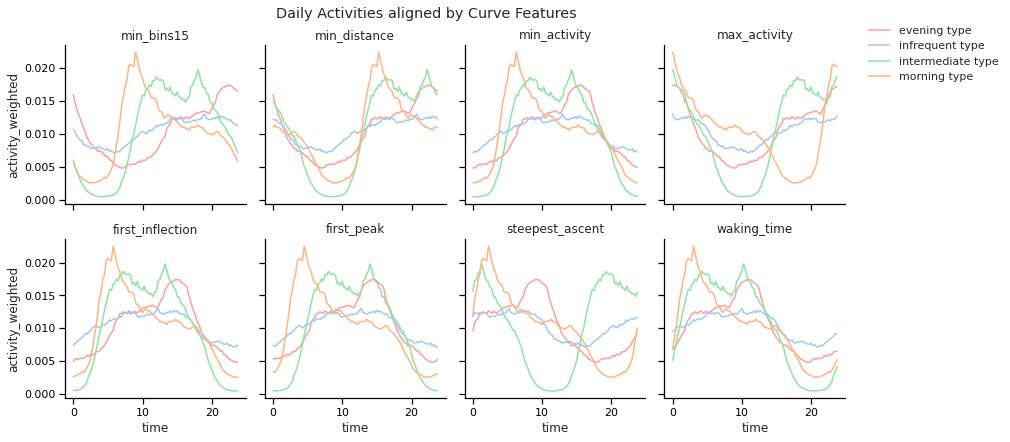

In [34]:
ssimilarity.plot_daily_activities(sp.activity, sp.c_col, y_col=activity_col, palette=Clusters.palette(), col_wrap=4, height=3,
                                  alignment_list=ssimilarity.ALIGNMNENT_LIST+['waking_time'])

In [35]:
sp.similarities.xs('features', level=0).style.highlight_min(props="font-weight: bold;", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,1.724286e+01,1.124104e-02,1.143322e-01,4.577664e+00,4.658554e-01,2.426330e-03,1.832255e-05
min_activity,1.569671e+01,1.303745e-02,1.476501e-01,4.955728e+00,5.921512e-01,3.084121e-03,2.954999e-05
max_activity,1.683028e+01,1.182037e-02,1.300906e-01,3.829294e+00,5.250605e-01,2.734690e-03,2.351923e-05
first_inflection,1.525038e+01,1.275709e-02,1.445415e-01,4.856292e+00,5.804520e-01,3.023187e-03,2.845002e-05
first_peak,1.533766e+01,1.374846e-02,1.518073e-01,5.027770e+00,6.088697e-01,3.171196e-03,3.119617e-05
steepest_ascent,1.704626e+01,8.428803e-03,1.007486e-01,3.519263e+00,4.069891e-01,2.119735e-03,1.505075e-05
waking_time,2.283399e+01,1.343511e-02,1.540834e-01,4.989933e+00,6.210914e-01,3.234851e-03,3.101753e-05


In [36]:
## sanity check - the diagonal needs to be minimised (except majority)
sp.similarities.xs('distance metrics', level=0).style.highlight_min(color="lightblue", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
pcm,9.007563e+00,7.089919e-03,7.422466e-02,3.222649e+00,2.998146e-01,1.561535e-03,7.205967e-06
frechet,9.978779e+00,6.632628e-03,7.336944e-02,3.280348e+00,2.965345e-01,1.544450e-03,6.833301e-06
area_between_two_curves,1.144055e+01,7.085155e-03,6.229426e-02,3.410665e+00,2.525373e-01,1.315299e-03,5.353851e-06
curve_length_measure,9.612673e+00,7.301534e-03,8.240982e-02,2.864306e+00,3.322555e-01,1.730497e-03,8.563823e-06
dtw,1.144055e+01,7.085155e-03,6.229426e-02,3.410665e+00,2.525373e-01,1.315299e-03,5.353851e-06
mae,1.144055e+01,7.085155e-03,6.229426e-02,3.410665e+00,2.525373e-01,1.315299e-03,5.353851e-06
mse,1.098967e+01,7.063876e-03,6.301235e-02,3.375807e+00,2.553322e-01,1.329855e-03,5.284129e-06
majority,1.144055e+01,7.085155e-03,6.229426e-02,3.410665e+00,2.525373e-01,1.315299e-03,5.353851e-06


In [37]:
sp.shift_by.style.applymap(lambda _: 'font-weight: bold', subset=pd.IndexSlice[:, 'majority']).format('{:.2f}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse,majority
cluster,,,,,,,,
evening type,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
infrequent type,-4.00,-1.00,-1.75,-3.50,-1.75,-1.75,-2.25,-1.75
intermediate type,-4.00,-5.25,-4.25,-6.00,-4.25,-4.25,-4.25,-4.25
morning type,-11.00,-9.75,-6.25,-12.00,-6.25,-6.25,-6.75,-6.25


In [38]:
hsp = ssimilarity.ColSimilarityProcessor(sp, ratio, ContentType.palette(), [True, False], i_col=ratio_col)
hsp.prep()

In [39]:
hsp.ratio_similarities.loc['features'].style.highlight_min(color="lightblue", axis=0).format('{:e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,4.024584e+01,1.911609e-01,2.456781e+00,3.512104e+00,9.930701e+00,5.172240e-02,6.119381e-03
min_activity,3.720912e+01,2.149594e-01,2.478123e+00,3.355133e+00,1.001542e+01,5.216362e-02,6.349012e-03
max_activity,2.965465e+01,2.161466e-01,2.482489e+00,3.801248e+00,1.003025e+01,5.224088e-02,6.617617e-03
first_inflection,3.690041e+01,2.056919e-01,2.469650e+00,3.317471e+00,9.967901e+00,5.191615e-02,6.285794e-03
first_peak,3.712953e+01,2.086196e-01,2.478014e+00,3.274453e+00,1.000126e+01,5.208990e-02,6.395246e-03
steepest_ascent,2.678950e+01,2.024262e-01,2.467753e+00,3.467844e+00,9.965309e+00,5.190265e-02,6.243122e-03
waking_time,2.909153e+01,2.138410e-01,2.485242e+00,3.380978e+00,1.001447e+01,5.215870e-02,6.536919e-03


In [40]:
activity_path_manager.to_latex(
    hsp.ratio_similarities.loc['features'].style.highlight_min(props='font-weight:bold', axis=0).format('{:1e}'),
    'similarity_ratio_by_activity',
    r"Distance metrics for the ratio of \harmful{} content when aligned by features of the cluster activity curves. See \cite{Witowski2012ParameterMapping, Frechet1906SurFonctionnel, Jekel2019SimilarityAnalysis,Andrade-Campos2012NovelParameters, Berndt1994UsingSeries} for details on the methods.",
    is_multi_index=False
)

### Smoothed

In [41]:
activity_smoothed.index.names=['min_bins15', 'cluster']

In [42]:
sp = ssimilarity.SimilarityProcessor(
    activity_smoothed,
    c_col=Columns.CLUSTER.value,
    a_col=activity_col,
    cluster_order=list(Clusters),
    waking_times=waking_times
)
sp.prep()

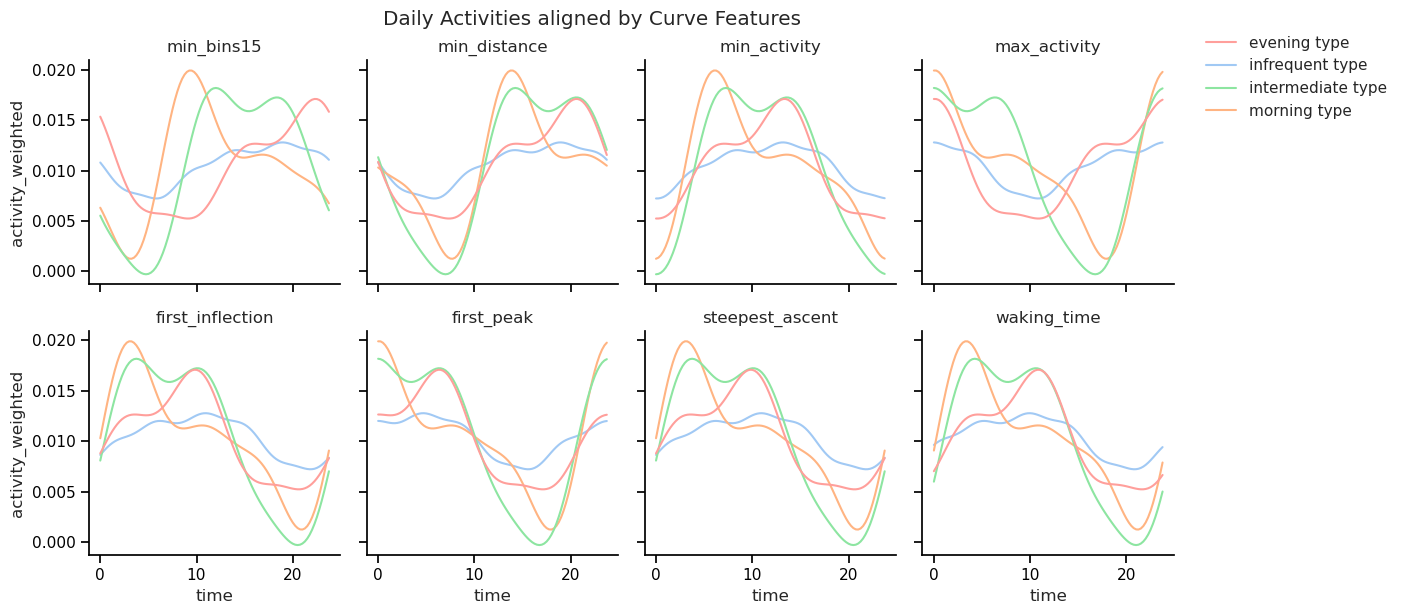

In [43]:
ssimilarity.plot_daily_activities(sp.activity, sp.c_col, y_col=activity_col, palette=Clusters.palette(), col_wrap=4,
                                  height=3,
                                  alignment_list=ssimilarity.ALIGNMNENT_LIST + ['waking_time'])

In [44]:
sp.similarities.xs('features', level=0).style.highlight_min(props="font-weight: bold;", axis=0).format('{:.1e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
min_bins15,3.0e+01,7.7e-03,8.8e-02,3.2e+00,3.6e-01,1.9e-03,9.9e-06
min_activity,3.5e+01,9.7e-03,1.1e-01,3.5e+00,4.3e-01,2.3e-03,1.5e-05
max_activity,3.6e+01,1.1e-02,1.3e-01,4.4e+00,5.2e-01,2.7e-03,2.0e-05
first_inflection,3.8e+01,9.6e-03,1.1e-01,3.8e+00,4.3e-01,2.2e-03,1.4e-05
first_peak,3.2e+01,9.5e-03,1.1e-01,4.1e+00,4.5e-01,2.4e-03,1.6e-05
steepest_ascent,3.8e+01,9.6e-03,1.1e-01,3.8e+00,4.3e-01,2.2e-03,1.4e-05
waking_time,3.5e+01,9.5e-03,1.1e-01,3.7e+00,4.3e-01,2.2e-03,1.5e-05


In [45]:
## sanity check - the diagonal needs to be minimised (except majority)
sp.similarities.xs('distance metrics', level=0).style.highlight_min(color="lightblue", axis=0).format('{:.1e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
pcm,2.4e+01,7.0e-03,8.0e-02,3.4e+00,3.2e-01,1.7e-03,8.4e-06
frechet,2.5e+01,6.6e-03,7.6e-02,3.4e+00,3.1e-01,1.6e-03,7.7e-06
area_between_two_curves,2.7e+01,7.0e-03,7.5e-02,3.1e+00,3.0e-01,1.6e-03,7.6e-06
curve_length_measure,2.8e+01,7.1e-03,7.6e-02,2.9e+00,3.0e-01,1.6e-03,7.8e-06
dtw,2.8e+01,7.0e-03,7.5e-02,3.0e+00,3.0e-01,1.6e-03,7.6e-06
mae,2.8e+01,7.0e-03,7.5e-02,3.0e+00,3.0e-01,1.6e-03,7.6e-06
mse,2.6e+01,6.8e-03,7.5e-02,3.2e+00,3.0e-01,1.6e-03,7.4e-06
majority,2.8e+01,7.0e-03,7.5e-02,3.0e+00,3.0e-01,1.6e-03,7.6e-06


In [46]:
sp.shift_by.style.applymap(lambda _: 'font-weight: bold', subset=pd.IndexSlice[:, 'majority']).format('{:.2f}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse,majority
cluster,,,,,,,,
infrequent type,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
morning type,-6.75,-4.75,-4.50,-5.00,-4.50,-4.50,-3.75,-4.50
intermediate type,-0.25,-1.00,-2.25,-2.25,-2.25,-2.25,-1.50,-2.25
evening type,-21.00,-20.50,-22.00,-23.00,-22.25,-22.25,-21.50,-22.25


In [47]:
ratio_smoothed.index.names=['min_bins15', 'cluster']

In [48]:
hsp = ssimilarity.ColSimilarityProcessor(sp, ratio_smoothed, ContentType.palette(), [True, False], i_col=ratio_col)
hsp.prep()

<p id="SupplTab7">Supplementary Table 7</p>

In [49]:
hsp.ratio_similarities.loc['features'].rename(index=lambda x: 'clock time' if x=="min_bins15" else x.replace("_", " ")).style.highlight_min(color="lightblue", axis=0).format('{:.1e}')

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
clock time,2.9e+01,9.9e-02,1.5e+00,3.4e+00,6.0e+00,3.1e-02,3.0e-03
min activity,2.4e+01,1.1e-01,1.5e+00,3.5e+00,6.2e+00,3.3e-02,3.3e-03
max activity,2.9e+01,1.3e-01,1.7e+00,4.1e+00,6.9e+00,3.6e-02,3.7e-03
first inflection,2.0e+01,1.2e-01,1.5e+00,3.4e+00,6.2e+00,3.2e-02,3.4e-03
first peak,1.8e+01,1.1e-01,1.6e+00,3.6e+00,6.4e+00,3.3e-02,3.3e-03
steepest ascent,2.0e+01,1.2e-01,1.5e+00,3.4e+00,6.2e+00,3.2e-02,3.4e-03
waking time,2.0e+01,1.1e-01,1.6e+00,3.5e+00,6.3e+00,3.3e-02,3.2e-03


In [50]:
activity_path_manager.to_latex(
    hsp.ratio_similarities.loc['features']
        .rename(index=lambda x: 'clock time' if x=="min_bins15" else x.replace("_", " "))
        .style.highlight_min(props='font-weight:bold', axis=0).format('{:.1e}'),
    'similarity_ratio_by_activity_fourier',
    r"Distance metrics for the ratio of \harmful{} content when aligned by features of the cluster activity curves. See \cite{Witowski2012ParameterMapping, Frechet1906SurFonctionnel, Jekel2019SimilarityAnalysis,Andrade-Campos2012NovelParameters, Berndt1994UsingSeries} for details on the methods.",
    is_multi_index=False
)

In [51]:
pd.crosstab(processor.all[Columns.CLUSTER.value], processor.all[Columns.FACTTYPE.value], margins=True) \
    .loc[[c for c in Clusters]+['bot', 'All'], [f.value.name for f in FactTypes] + ['All']].T

cluster,infrequent type,morning type,intermediate type,evening type,bot,All
FactType2,,,,,,
Science,7251,4028,3333,4219,0,18831
Mainstream Media,251854,162321,214545,128747,194,757661
Satire,2430,534,721,616,0,4301
Clickbait,8769,1214,984,1230,0,12197
Other,7536310,2988656,3902167,2720735,63119,17210987
Political,32948,20718,13944,31090,0,98700
Fake or hoax,9876,10344,9513,14155,0,43888
Conspiracy & junk science,8771,20669,17704,18517,0,65661
All,7858209,3208484,4162911,2919309,63313,18212226


In [52]:
t = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.FACTTYPE])

In [53]:
ratio_by_ft_and_cluster_user = t[Columns.RATIO_BY_USER.value].unstack(level=0).loc[[i.value.name for i in FactTypes.known_order()], list(Clusters)]
ratio_by_ft_and_cluster_user.loc[ContentType.MANIPULATED.value] = ratio_by_ft_and_cluster_user.loc[[i.value.name for i in FactTypes.harmful_order()]].sum(axis=0)
ratio_by_ft_and_cluster_user

cluster,infrequent type,morning type,intermediate type,evening type
FactType2,,,,
Science,0.027831,0.020545,0.016946,0.020468
Mainstream Media,0.742780,0.779764,0.821459,0.695310
Satire,0.008045,0.003716,0.005323,0.004127
Clickbait,0.075731,0.007907,0.004756,0.008475
Political,0.106802,0.077665,0.056669,0.146369
Fake or hoax,0.027132,0.040394,0.036717,0.058508
Conspiracy & junk science,0.011678,0.070010,0.058130,0.066742
potentially machinated,0.145612,0.188068,0.151516,0.271619


In [54]:
ratio_by_ft_and_cluster_tweet = t[Columns.RATIO_BY_TWEET.value].unstack(level=0).loc[[i.value.name for i in FactTypes.known_order()], list(Clusters)]
ratio_by_ft_and_cluster_tweet.loc[ContentType.MANIPULATED.value] = ratio_by_ft_and_cluster_tweet.loc[[i.value.name for i in FactTypes.harmful_order()]].sum(axis=0)
ratio_by_ft_and_cluster_tweet

cluster,infrequent type,morning type,intermediate type,evening type
FactType2,,,,
Science,0.022526,0.018323,0.012783,0.021246
Mainstream Media,0.782401,0.738400,0.822819,0.648358
Satire,0.007549,0.002429,0.002765,0.003102
Clickbait,0.027241,0.005522,0.003774,0.006194
Political,0.102355,0.094246,0.053478,0.156566
Fake or hoax,0.030680,0.047055,0.036484,0.071283
Conspiracy & junk science,0.027248,0.094024,0.067898,0.093250
potentially machinated,0.160283,0.235325,0.157860,0.321099


In [55]:
activity_path_manager.to_latex(
    spearman_df
    .style
    .format(
        {(c,r):f for r,f in zip(
            ['Rho', 'P-Value'],
            [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
         for c in spearman_df.columns.unique(level=0)})
    .applymap(
        lambda v: 'font-weight: bold;' if (v <0.05)  else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]]
    ),
    'spearman_harmful_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's total activity as well as activity level throughout the day with the ratio of harmful content spread, including politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)

<p id="SupplTab6">Supplementary Table 6</p>

In [56]:
ratio_by_ft_and_cluster_user_style = ratio_by_ft_and_cluster_user[list(Clusters)].rename(columns={c:c.split()[0] for c in list(Clusters)}).style.format('{:.03f}')
ratio_by_ft_and_cluster_user_style

cluster,infrequent,morning,intermediate,evening
FactType2,,,,
Science,0.028,0.021,0.017,0.020
Mainstream Media,0.743,0.780,0.821,0.695
Satire,0.008,0.004,0.005,0.004
Clickbait,0.076,0.008,0.005,0.008
Political,0.107,0.078,0.057,0.146
Fake or hoax,0.027,0.040,0.037,0.059
Conspiracy & junk science,0.012,0.070,0.058,0.067
potentially machinated,0.146,0.188,0.152,0.272


In [57]:
activity_path_manager.to_latex(
    ratio_by_ft_and_cluster_user_style,
    'content_type_ratios',
    caption=r"Ratios of posts by content type and cluster. Ratios are negatively weighted by the author's total number of posts.",
    is_multi_index=True
)

### Comparing populations

Evening types post significantly more potentially machinated content than the other clusters, particularly fake or hoax content and politically biased news. Infrequent type users post disproportionately much Clickbait.

In [58]:
by_cluster_h = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.MACHINATED], total_for_idx=-2)

In [59]:
by_cluster_i = sprocessing.group_by_with_total(processor.all.loc[type_mask & known_mask], group_by_cols=[Columns.CLUSTER, Columns.FACTTYPE], total_for_idx=-2)

In [60]:
chi2mp=pd.DataFrame(index=[Columns.MACHINATED.value, Columns.FACTTYPE.value], columns=pd.MultiIndex.from_product((([Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]), ('Chi2', 'P-value'))))
for r in [Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]:
    for df in [by_cluster_h, by_cluster_i]:
        ratio_contingency_table=sutils.get_chi2_table(
            df.loc[list(Clusters)],
            ratio_col=r,
            x_col=df.index.names[-1],
            y_col=Columns.CLUSTER.value,
            nr_tries_col=Columns.NUM_POSTS.value)
        chi2mp.loc[df.index.names[-1], r] = stats.chi2_contingency(ratio_contingency_table.round().iloc[:-1].T)[:2]

In [61]:
chi2mp

ratio_norm                 ratio        
                   Chi2 P-value          Chi2 P-value
harmful    15330.980565     0.0  24235.605591     0.0
FactType2  54033.016107     0.0   40408.21172     0.0

In [62]:
activity_path_manager.to_latex(
    chi2mp.style.format('{:.0f}').format('{:.1e}', subset=[(i, 'P-value') for i in (Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value)]),
    'chi_square',
    caption=r"Chi Square test of difference in distributions in between content types.",
    is_multi_index=True
)

 The p-values are smaller than 0.05 and therefore tells us that the clusters show statistically significant differences in their distributions between content types.
Our null hypothesis (user cluster and spreading of harmful content/content types are independent) can be rejected.

## Diurnal variations

In [17]:
by_cluster_f_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER], ratio_for_idx=1)

<p id="Figure4">Figure 4</p>

Text(0.5, 0.98, 'Figure 4')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


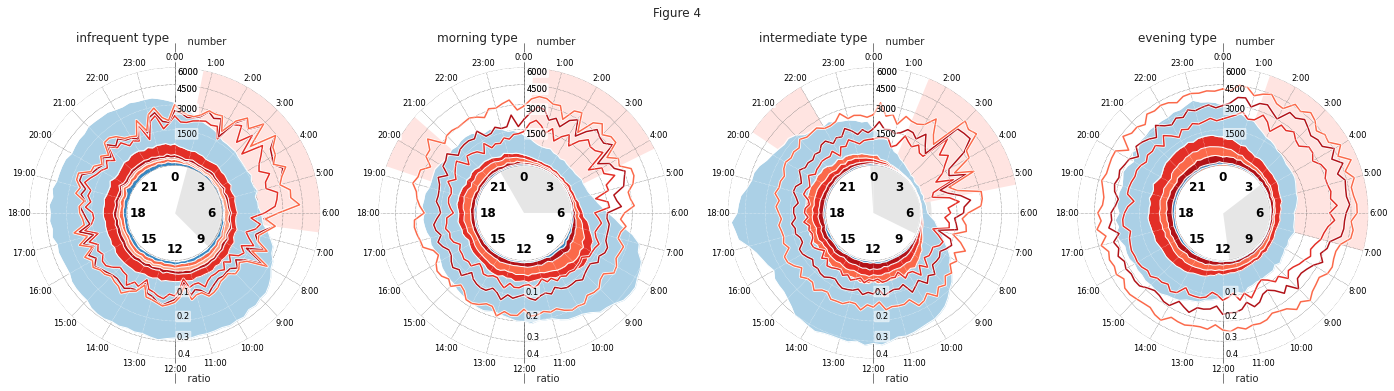

In [18]:
import matplotlib.font_manager
fig, axes = await sclockface.theme_circle_helper(
    df=by_cluster_f_time.rename(columns={
        Columns.NUM_POSTS.value: "    number",
        Columns.RATIO_BY_USER.value: "    ratio"
    }),
    usecols=["    number"],
    facet_col=Columns.CLUSTER.value,
    hue_col=Columns.FACTTYPE.value,
    palette=FactTypes.palette(),
    susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
    facetorder=list(Clusters),
    perline=4,  mul=6,
    waking_times=waking_times,
    susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
    bar_func=sclockface.simple_area_stack,
    line_col=f'    ratio',
    share_h=True,
    project_area=True,
    line_order=[i.value.name for i in FactTypes.harmful_order()])
fig.suptitle("Figure 4")

/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset
The PostScript backend does not s

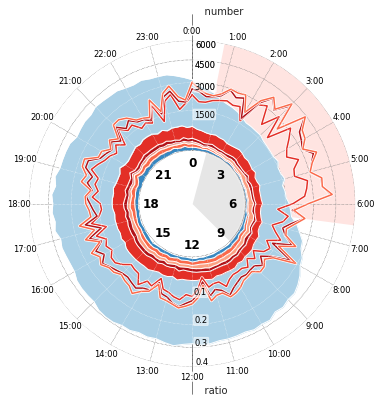

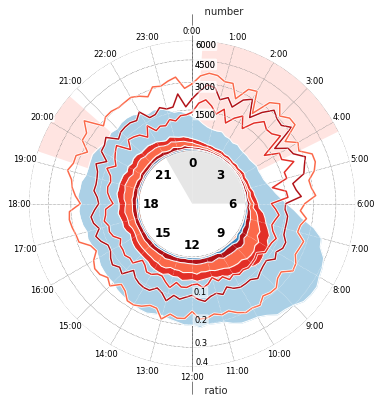

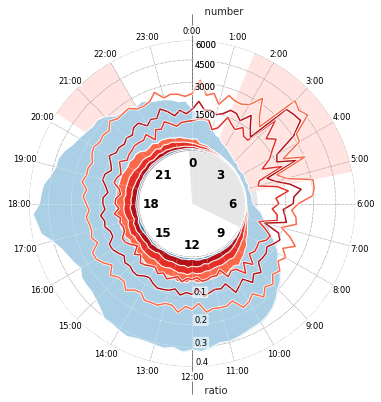

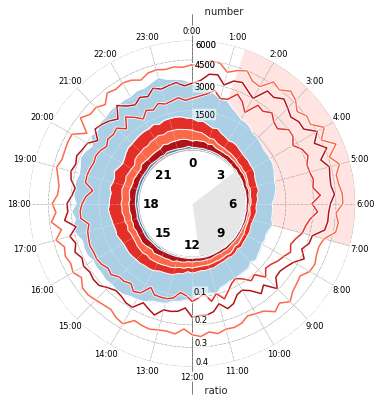

In [19]:
for c in Clusters:
    fig, axes = await sclockface.theme_circle_helper(
        df=by_cluster_f_time.rename(columns={
            Columns.NUM_POSTS.value: "    number",
            Columns.RATIO_BY_USER.value: "    ratio"
        }),
        usecols=["    number"],
        facet_col=Columns.CLUSTER.value,
        hue_col=Columns.FACTTYPE.value,
        palette=FactTypes.palette(),
        susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
        facetorder=[c],
        perline=1,  mul=6,
        waking_times=waking_times,
        susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
        bar_func=sclockface.simple_area_stack,
        line_col=f'    ratio',
        share_h=True,
        project_area=True,
        title=False,
        line_order=[i.value.name for i in FactTypes.harmful_order()])
    fig.savefig(f"{config.SAVE_ROOT_DIR}clockface/{country_config.LABEL}/{c.split()[0]}_{TYPE}.eps", dpi=300, transparent=False)


Above we see:
- as a stackplot: the cumulative number of posts where reliability is known throughout the day, sorted by the  amount of posts of the type throughout the day.
- as a lineplot: with intermittent hatching the  **cumulative ratios** of potentially machinated content types (weighted by 1/num posts per user)
- within the inner shaded grey area: the time when users typically asleep
- within the red shaded background areas the times where the ratio of harmful posts is highest (red, 4th quantile)

Generally, infrequent types have lowest ratios of potentially machinated content types. Evening type individuals post higher baseline rates of potentially machinated content.

In [20]:
by_cluster_f_time_all = sprocessing.group_by_with_total(
    processor.all, group_by_cols=[Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER], ratio_for_idx=1)

/data/estockinger/code/scripts/clockface_plots.py:77: RuntimeWarning: invalid value encountered in sqrt
  return ((value + v_offset) * alpha) ** 0.5 + r_offset


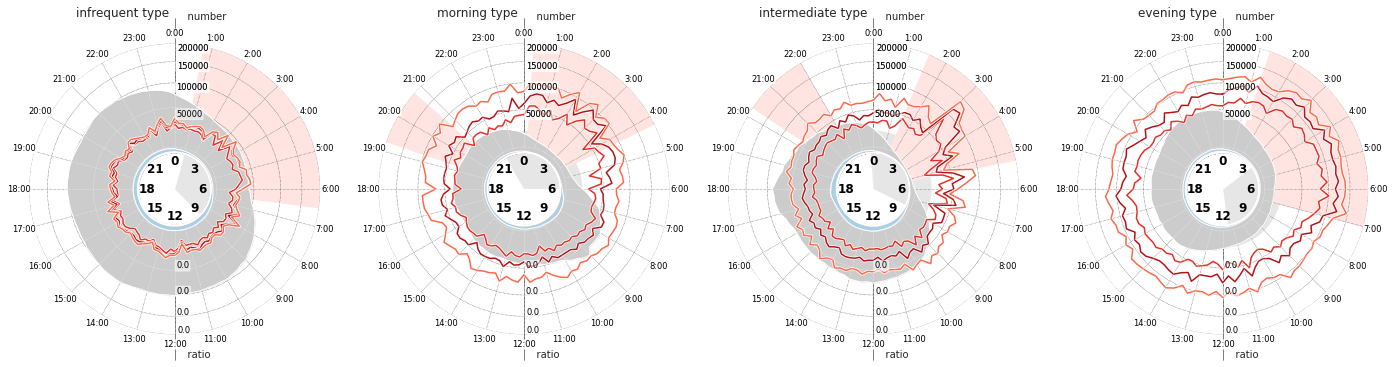

In [21]:
fig, axes = await sclockface.theme_circle_helper(
    df=by_cluster_f_time_all.rename(columns={
        Columns.NUM_POSTS.value: "    number",
        Columns.RATIO_BY_USER.value: "    ratio"
    }),
    usecols=["    number"],
    facet_col=Columns.CLUSTER.value,
    hue_col=Columns.FACTTYPE.value,
    palette=FactTypes.palette(),
    susceptible_df=ratio_smoothed[ratio_col].unstack(level=Columns.CLUSTER.value),
    facetorder=list(Clusters),
    perline=4,  mul=6, # the higher, the smaller font sizes
    waking_times=waking_times,
    susceptible_kwargs=dict(quantile=0.25, window_size=8, pad_by=4, std=3, n=4),
    bar_func=sclockface.simple_area_stack,
    line_col=f'    ratio',
    share_h=True,
    project_area=True,
    line_order=[i.value.name for i in FactTypes.harmful_order()])

# Lockdown and harmful content

In [22]:
processor.all[Columns.LOCKDOWN.value] = (('2020-03-09' <= processor.all[Columns.LOCAL_TIME.value]) & (processor.all[Columns.LOCAL_TIME.value] <= '2020-05-18'))
# | (('2020-11-05' <= sp.df['local_time']) & (sp.df['local_time'] <= '2020-12-01'))
h_during_lockdown=sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.LOCKDOWN, Columns.CLUSTER, Columns.MACHINATED],
    total_for_idx=-2)

In [23]:
processor.all[Columns.EMERGENCY.value] = (('2020-01-31' <= processor.all[Columns.LOCAL_TIME.value]) & (processor.all[Columns.LOCAL_TIME.value] <= '2022-03-31'))
h_during_emergency=sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.MIN_BINS15, Columns.EMERGENCY, Columns.CLUSTER, Columns.MACHINATED],
    total_for_idx=-2)

In [24]:
statdf_covid=pd.DataFrame(0, index=list(Clusters)+['total'], columns=pd.MultiIndex.from_product(((Columns.LOCKDOWN.value, Columns.EMERGENCY.value), ['Statistic', 'P-Value'])))

for c in statdf_covid.index:
    tmp_df = h_during_lockdown.xs((c, True), level=(Columns.CLUSTER.value, Columns.MACHINATED.value))[ratio_col]
    stat,p = stats.mannwhitneyu(tmp_df.xs(True, level=Columns.LOCKDOWN.value), tmp_df.xs(False, level="in_lockdown"), alternative='less')
    statdf_covid.loc[c, Columns.LOCKDOWN.value] = stat,p
    tmp_df = h_during_emergency.xs((c, True), level=(Columns.CLUSTER.value, Columns.MACHINATED.value))[ratio_col]
    stat,p = stats.mannwhitneyu(tmp_df.xs(True, level=Columns.EMERGENCY.value), tmp_df.xs(False, level="emergency"), alternative='less')
    statdf_covid.loc[c, Columns.EMERGENCY.value] = stat,p

In [25]:
statdf_covid

in_lockdown               emergency              
                    Statistic       P-Value Statistic       P-Value
infrequent type          3598  4.369659e-03      3082  3.710766e-05
morning type             2038  1.244207e-11      1950  2.552591e-12
intermediate type        1383  1.270980e-16      2257  1.351112e-09
evening type             2813  1.572966e-06      4424  3.168146e-01
total                    3597  4.336469e-03      3081  3.670591e-05

In [26]:
lockdown_df = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask],
    group_by_cols=[Columns.CLUSTER, Columns.MACHINATED, Columns.LOCKDOWN],
    total_for_idx=0,
    ratio_for_idx=1)

In [27]:
users_per_cluster = processor.all.loc[type_mask & known_mask].groupby([Columns.CLUSTER.value])[Columns.USER.value].nunique()
users_per_cluster['total']=users_per_cluster.sum()
users_per_cluster

cluster
evening type           3206
infrequent type      117746
intermediate type      3496
morning type           3259
total                127707
Name: User, dtype: int64

In [28]:
lockdown_days= { 
    True: len(processor.all.loc[type_mask & known_mask & (processor.all[Columns.LOCKDOWN.value]), Columns.LOCAL_TIME.value].dt.date.unique()),
    False: len(processor.all.loc[type_mask & known_mask & ~(processor.all[Columns.LOCKDOWN.value]), Columns.LOCAL_TIME.value].dt.date.unique())
}
def posts_per_day(x, row, num_users=None):
    cluster, lockdown = row.name
    return row[x]/lockdown_days[lockdown]/(1 if num_users is None else num_users[cluster])

In [29]:
lockdown_stat_df = (lockdown_df
    .loc[lockdown_df.index.get_level_values(level=Columns.LOCKDOWN.value)!="total"]
    .xs(True, level=Columns.MACHINATED.value)[[Columns.RATIO_BY_USER.value, Columns.NUM_POSTS.value]])
lockdown_stat_df['num_posts_total'] = num_posts_by_lockdown=lockdown_df.groupby(level=[Columns.CLUSTER.value, Columns.LOCKDOWN.value])[Columns.NUM_POSTS.value].sum()
lockdown_stat_df["posts_per_day_and_user"]=lockdown_stat_df.apply(lambda row: posts_per_day(Columns.NUM_POSTS.value, row, users_per_cluster), axis=1)
lockdown_stat_df["harmful_posts_per_day_and_user"]=lockdown_stat_df.apply(lambda row: posts_per_day('num_posts_total', row, users_per_cluster), axis=1)
lockdown_stat_df = lockdown_stat_df[[Columns.RATIO_BY_USER.value, 'harmful_posts_per_day_and_user', 'posts_per_day_and_user']].unstack(level=1)
for i in [Columns.RATIO_BY_USER.value, 'harmful_posts_per_day_and_user', 'posts_per_day_and_user']:
    lockdown_stat_df[i, 'diff']= lockdown_stat_df[i, True] - lockdown_stat_df[i, False]
lockdown_stat_df.sort_index(axis=1, inplace=True)
lockdown_stat_df.columns=pd.MultiIndex.from_product(((f'{ContentType.MANIPULATED.value} posts/day/user','posts/day/user', f'ratio of {ContentType.MANIPULATED.value} content'),('no lockdown', 'lockdown', 'change')))
lockdown_stat_df.index.name=None
lockdown_stat_df.T

evening type  \
potentially machinated posts/day/user   no lockdown      0.063930   
                                        lockdown         0.104888   
                                        change           0.040958   
posts/day/user                          no lockdown      0.020777   
                                        lockdown         0.030635   
                                        change           0.009857   
ratio of potentially machinated content no lockdown      0.276273   
                                        lockdown         0.243819   
                                        change          -0.032453   

                                                     infrequent type  \
potentially machinated posts/day/user   no lockdown         0.002659   
                                        lockdown            0.006614   
                                        change              0.003955   
posts/day/user                          no lockdown         0.000437   
                                        lockdown            0.000922   
                                        change              0.000485   
ratio of potentially machinated content no lockdown         0.149345   
                                        lockdown            0.127994   
                                        change             -0.021351   

                                                     intermediate type  \
potentially machinated posts/day/user   no lockdown           0.077413   
                                        lockdown              0.121040   
                                        change                0.043627   
posts/day/user                          no lockdown           0.012679   
                                        lockdown              0.013509   
                                        change                0.000830   
ratio of potentially machinated content no lockdown           0.156917   
                                        lockdown              0.112715   
                                        change               -0.044202   

                                                     morning type     total  
potentially machinated posts/day/user   no lockdown      0.068472  0.007923  
                                        lockdown         0.128247  0.015317  
                                        change           0.059775  0.007394  
posts/day/user                          no lockdown      0.016580  0.001695  
                                        lockdown         0.024482  0.002614  
                                        change           0.007901  0.000919  
ratio of potentially machinated content no lockdown      0.193892  0.149394  
                                        lockdown         0.156406  0.128022  
                                        change          -0.037487 -0.021371

In [30]:
lockdown_contingency=processor.all.loc[type_mask & known_mask].groupby([Columns.MACHINATED.value, Columns.LOCKDOWN.value])[Columns.TWEET_ID.value].count().unstack(level=1)

In [31]:
stats.chi2_contingency(lockdown_contingency)

(1344.1657854462865,
 2.854298930227385e-294,
 1,
 array([[684351.7679425, 108444.2320575],
        [179763.2320575,  28485.7679425]]))

<p id="Table4">Table 4</p>

In [32]:
lockdown_stat_df_style = lockdown_stat_df.T[list(Clusters)].style.format('{:.3f}', na_rep="-")
lockdown_stat_df_style

In [33]:
activity_path_manager.to_latex(
    lockdown_stat_df_style,
    'stats_lockdown',
    caption=r"Number of posts and ratio of harmful content during and outside of the lockdown period.",
    is_multi_index=True
)

# Sunlight

In [11]:
m_over_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask & (processor.all[Columns.LOCAL_TIME.value] < '2022-08-01')],
    group_by_cols = [Columns.YEAR, Columns.MONTH, Columns.MIN_BINS15, Columns.MACHINATED, Columns.CLUSTER],
    ratio_for_idx=-2, total_for_idx=-1,
    aggregate_cols=[Columns.LAT, Columns.LONG]
)

In [12]:
df_monthly = m_over_time.xs('total', level=Columns.CLUSTER.value)

In [13]:
from suntime import Sun
import datetime, pytz, math

lat = df_monthly[Columns.LAT.value].mean()
long = df_monthly[Columns.LONG.value].mean()
sun = Sun(lat, long)
tz = pytz.timezone(country_config.TIME_ZONE)

def to_bin(timeobj):
    timeobj = timeobj.time()
    return (((timeobj.hour*3600)+(timeobj.minute*60))//900)*0.25


sun_times = {}
for i in range(1,13):
    date = datetime.date(2020, i, 1)
    sun_times[i] = {
        "sunrise":  to_bin(sun.get_local_sunrise_time(date).astimezone(tz)),
        "sunset":  to_bin(sun.get_local_sunset_time(date).astimezone(tz))
    }

sun_times = pd.DataFrame.from_dict(sun_times, orient='index')
years_spanned = math.ceil(np.ptp(processor.all.loc[type_mask, Columns.LOCAL_TIME.value]).days/365)
sun_times_total = pd.concat([sun_times for _ in range(years_spanned)]).reset_index(drop=True)
daytimes=round(sun_times_total.mean()*4)/4

In [14]:
daytimes

sunrise     6.50
sunset     18.75
dtype: float64

In [15]:
palette=["lightblue", "coral", "darkred"]
cmap=sns.color_palette("blend:"+",".join(palette), as_cmap=True)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


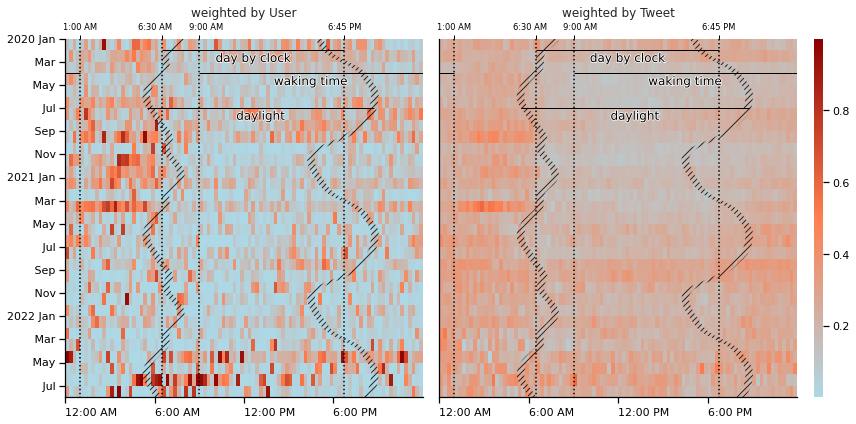

In [16]:
import matplotlib.font_manager
cols=[Columns.RATIO_BY_USER.value, Columns.RATIO_BY_TWEET.value]
fig, axes = sheatmap.plot_heatmap_facets(
    m_over_time.xs((True, 'total'), level=(Columns.MACHINATED.value, Columns.CLUSTER.value))[cols],
    sun_times=sun_times_total, waking_times={c: waking_times['total'] for c in cols}, day_times=daytimes,
    columns=cols, subtitles=["weighted by User", "weighted by Tweet"], figsize=(12,6), cmap=cmap, edgecolor="black");

<p id="Figure3">Figure 3</p>

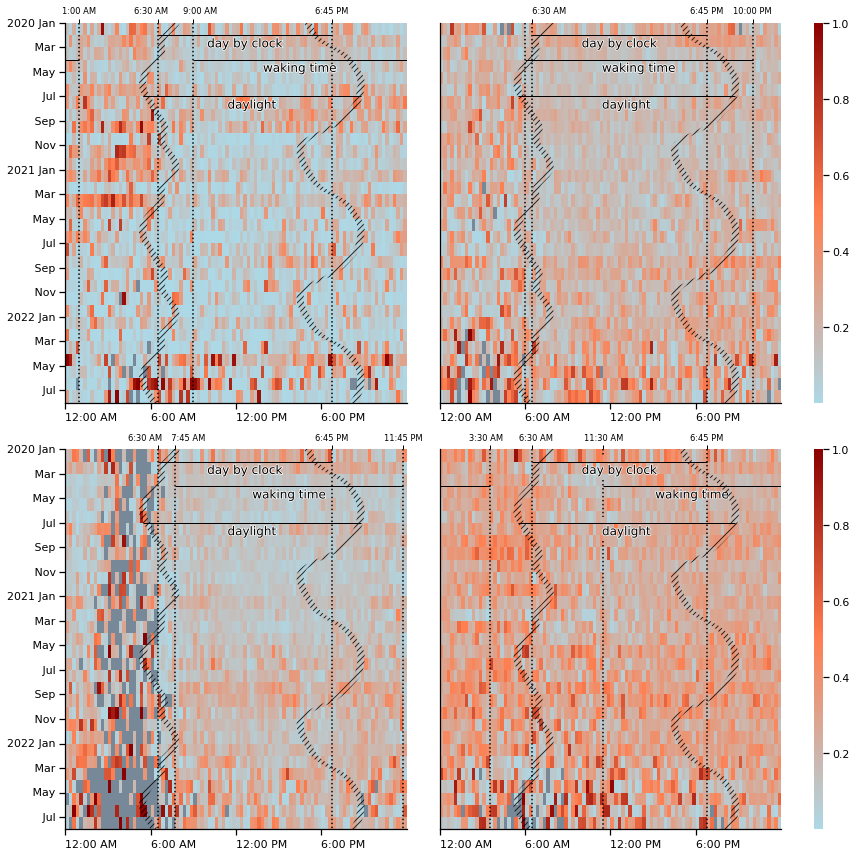

In [17]:
fig, _ = sheatmap.plot_heatmap_facets(
    m_over_time.xs(True, level=Columns.MACHINATED.value)[Columns.RATIO_BY_USER.value].unstack(level=Columns.CLUSTER.value),
    sun_times=sun_times_total, waking_times={i:waking_times[i] for i in Clusters}, day_times=daytimes,
    columns=list(Clusters), subtitles = [],
    figsize=(12,12), cmap=cmap, facecolor='lightslategrey', nrows=2, ncols=2, edgecolor="black")

In [18]:
bbox_for_cluster = {
    # left, bottom, right, top
    'infrequent': (0,6,6,12),
    'morning': (6,6,12,12),
    'intermediate': (0,0,6,6),
    'evening': (6,0,12,6)
}
for c, b in bbox_for_cluster.items():
    fig.savefig(f"{config.SAVE_ROOT_DIR}heatmap/{country_config.LABEL}/{c}_{TYPE}.eps", dpi=300, transparent=False, bbox_inches=mpl.transforms.Bbox.from_extents(b))

### By FactType

In [ ]:
f_over_time = sprocessing.group_by_with_total(
    processor.all.loc[type_mask & known_mask & (processor.all[Columns.LOCAL_TIME.value] < '2022-08-01')],
    group_by_cols = [Columns.YEAR, Columns.MONTH, Columns.MIN_BINS15, Columns.FACTTYPE, Columns.CLUSTER],
    ratio_for_idx=-2, total_for_idx=-1
)

In [ ]:
import matplotlib.font_manager
fig, axes = sheatmap.plot_heatmap_facets(
    f_over_time.xs('total', level=Columns.CLUSTER.value)['ratio_norm'].unstack(level=sconstants.f_col),
    sun_times=sun_times_total, waking_times={i:waking_times['total'] for i in FactTypes.known_order('name')}, day_times=daytimes,
    columns=FactTypes.known_order('name'), subtitles = FactTypes.known_order('name'),
    figsize=(30,6), cmap=cmap, facecolor='lightslategrey', nrows=1, ncols=7)

### Statistics

In [59]:
sday.get_waking_time(m_over_time, daytimes, waking_times, sun_times_total, safety_margin=(1,1))
sday.get_waking_time(f_over_time, daytimes, waking_times, sun_times_total, safety_margin=(1,1))

In [ ]:
for c in list(Clusters)+['total']:
    tmpdf=m_over_time.xs((True, c), level=(Columns.MACHINATED.value, Columns.CLUSTER.value))[Columns.RATIO_BY_USER.value]
    print(f'{c}: {stats.shapiro(tmpdf)}')

Our data is not normally distributed.

In [61]:
shared_args = {
    'ratio_col': Columns.RATIO_BY_USER.value,
    'test': stats.mannwhitneyu,
}
m_stat_df = sday.pair_cols(m_over_time, Columns.MACHINATED.value, ivals=[True], **shared_args)
f_stat_df = sday.pair_cols(f_over_time, Columns.FACTTYPE.value, ivals=FactTypes.harmful_order('name'), **shared_args)

Find which distribution was lower (day or night) only for those values where p was significant:

In [62]:
threshold=.05
stat_df = pd.concat([
        sday.find_distribution_side(m_stat_df, threshold=threshold).rename(index={True: ContentType.MANIPULATED.value}),
        sday.find_distribution_side(f_stat_df, threshold=threshold).loc[FactTypes.harmful_order('name')]
    ])

<p id="Table3">Table 3</p>

In [63]:
stat_df_style =(
    stat_df.loc[stat_df.index.get_level_values(1).isin(list(Clusters))]
    .rename(columns={
        'daytime': r'6:30am - 6:45pm\tnote{1}',
        'suntime': r'sunrise - sunset\tnote{2}',
        'waking_time': r'waking - bedtime\tnote{3}'
    })
    .style
    .format('{:,.0f}', subset=pd.IndexSlice[:, pd.IndexSlice[:, "Statistic"]])
    .format('{:.1e}', subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
    .applymap(
        lambda v: 'font-weight: bold;' if (v < 0.05) else None,
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
)
stat_df_style

In [64]:
activity_path_manager.to_latex(
    stat_df_style,
    'mannwhitneyu_daysunwaking',
    caption=r"One-sided Mann-Whitney U test indicating whether the distribution of ratios of \harmful{} content throughout the day (see \autoref{fig:fourier_activity_clocktime}) underlying one cluster (rows) is smaller than that of another cluster (columns).",
    is_multi_index=True
)